# Recommender System with Book Rating Data

In this notebook, we focuses on visualizing the book rating data, as well as prepare the data for a recommender system based on collaborative filtering. This notebook is split into three parts:

**Section I:** explores the dataset to find interesting patterns <br />
**Section II:** prepare the dataset for collaborative filtering <br />
**Section III:** introduce and demonstrate collaborative filtering

### Section I:   
### Data Visualization and Exploratory Analysis

#### Load library
We start by loading some libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import json
from pandas.io.json import json_normalize

#### Read data

We read three datafiles as dataframes. Where

*'BX-CSV-Dump/book-crossing_users.json'* has the user information <br />
*'BX-CSV-Dump/book-crossing_books.json'* has the book information <br />
*'BX-CSV-Dump/book-crossing_explicit_ratings.json'* has the users' ratings on books <br />

The describtions of the dataset can be found [Here](http://www2.informatik.uni-freiburg.de/~cziegler/BX/)

In [3]:
# Import Users file as dataframe
with open('BX-CSV-Dump/book-crossing_users.json') as data_file:
    data = data_file.readlines()
# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
User = pd.read_json(data_json_str)

In [4]:
# Import Books file as dataframe
with open('BX-CSV-Dump/book-crossing_books.json') as data_file:
        data = data_file.readlines()
# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
Books = pd.read_json(data_json_str)

In [5]:
# Import Ratings file as dataframe
# Note that duplicate entries of ratings have already been removed
# Also users who do not rate at least one book has been removed
# Books not receiving as least one review have been removed from rating matrix
# Only Explicit Ratings are loaded and analysed
with open('BX-CSV-Dump/book-crossing_explicit_ratings.json') as data_file:
        data = data_file.readlines()
# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
df = pd.read_json(data_json_str)

#### Have a look at the dataset

First, let's have a look at the dataset. Dataframe **df** contains users' ratings of books (a total of 383852 ratings, for 149842 books, from 68092 users). <br />

While dataframe **Books** contains more information on the books such as title, autor, year and publisher. 

The dataframe **User** has other user information, such as location and age <br />

Here we print out heads of ratings, Books, and User dataframe 

In [6]:
df.head()

,book_id,implicit,rating,user_id
0,0155061224,NaN,5,276726
1,052165615X,NaN,3,276729
2,0521795028,NaN,6,276729
3,038550120X,NaN,7,276744
4,0060517794,NaN,9,276747


In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383852 entries, 0 to 383851
Data columns (total 4 columns):
book_id     383852 non-null object
implicit    0 non-null float64
rating      383852 non-null int64
user_id     383852 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 11.7+ MB
None


##### Number of books and number of users

In [8]:
# Get Number of Users and Number of Books
n_users = df.user_id.nunique()
n_books = df.book_id.nunique()

print('Num. of Users: ' + str(n_users))
print('Num of Books: ' + str(n_books))

Num. of Users: 68092
Num of Books: 149842


##### Books and User dataframe

In [9]:
Books.head()

,author,book_id,publisher,title,year
0,Mark P. O. Morford,0195153448,Oxford University Press,Classical Mythology,2002
1,Richard Bruce Wright,0002005018,HarperFlamingo Canada,Clara Callan,2001
2,Carlo D'Este,0060973129,HarperPerennial,Decision in Normandy,1991
3,Gina Bari Kolata,0374157065,Farrar Straus Giroux,Flu: The Story of the Great Influenza Pandemic...,1999
4,E. J. W. Barber,0393045218,W. W. Norton &amp; Company,The Mummies of Urumchi,1999


In [10]:
User.head()

,age,location,user_id
0,18.0,"stockton, california, usa",2
1,NaN,"timmins, ontario, canada",8
2,NaN,"germantown, tennessee, usa",9
3,26.0,"albacete, wisconsin, spain",10
4,NaN,"fort bragg, california, usa",12


#### Select a subset of ratings

To reduce calculation times in this kernel, I select only a subset of ratings. (e.g., 20%) Now the subset has **24128 Users** and **43280 Books**

In [11]:
fraction = 0.2
size = df['book_id'].count()
index = np.random.randint(0, size, int(size*fraction))
df = df.iloc[index]

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76770 entries, 380622 to 217961
Data columns (total 4 columns):
book_id     76770 non-null object
implicit    0 non-null float64
rating      76770 non-null int64
user_id     76770 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.9+ MB


Drop the unneccesary columns in dataframe df

In [13]:
# Get Number of Users and Number of Books
n_users = df.user_id.nunique()
n_books = df.book_id.nunique()

print('Num. of Users: ' + str(n_users))
print('Num of Books: ' + str(n_books))

Num. of Users: 24335
Num of Books: 43431


#### Now let's start exploring the dataset by visualize them!

##### Q1: What is the distribution of ratings?

We see that most of the ratings are quite positive in 6-9 range. We also observed that there are several peaks at rating score 5, 6, 7, 8, 9, 10. This is simply because many of the books only receive one rating, and its rating is an integer. So we have so many ratings that are integers instead of a mean value of many ratings.

In [14]:
# Group the books and their ratings in the dataframe ratings
sns.set_style('white')
ratings = pd.DataFrame(df.groupby('book_id')['rating'].mean())
ratings['num of ratings'] = pd.DataFrame(df.groupby('book_id')['rating'].count())
ratings.head()

,rating,num of ratings
book_id,,
0001047213,9.0,1
000104799X,7.0,1
0001056107,8.0,1
0001061127,8.0,1
0001360469,10.0,1


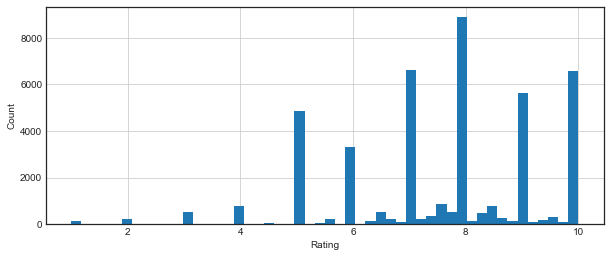

In [15]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=50)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

##### Q2: How does the number of ratings per book distribute?

We can see that most of the books only receive one rating. This makes sence because many books receive only one rating. 

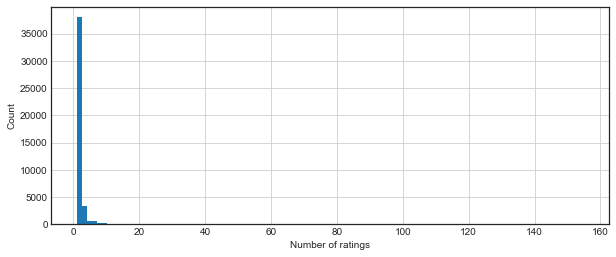

In [16]:
plt.figure(figsize=(10,4))
ratings['num of ratings'].hist(bins=100)
plt.xlabel('Number of ratings')
plt.ylabel('Count')
plt.show()

A jointplot shows how ratings and num of ratings distribute

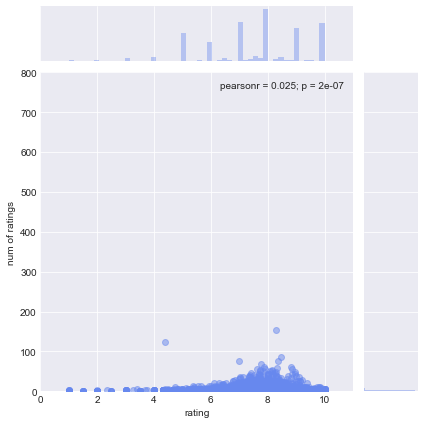

In [17]:
sns.set_style('darkgrid')
sns.set_palette('coolwarm')
sns.jointplot(x='rating',y='num of ratings',data=ratings, alpha=0.5, xlim = (0,11), ylim = (0, 800))

#### Q3: What is the number of ratings per user?

Most of the users only give one rating. The number of ratings per user seems to exponentially decaying. The users who only rate 1 or 2 books do not provide much information on recommending. So I will filter out these users have less than 3 ratings later.

In [18]:
userrating = pd.DataFrame(columns=['num of ratings'])
userrating['rating'] = df.groupby('user_id')['rating'].mean()
userrating['num of ratings'] = df.groupby('user_id')['rating'].count()
userrating.head()

,num of ratings,rating
user_id,,
8,2,5.0
14,4,6.0
53,1,6.0
87,1,8.0
97,1,7.0


The maximum number of ratings from one user is: 1408
The minimum number of ratings from one user is: 1


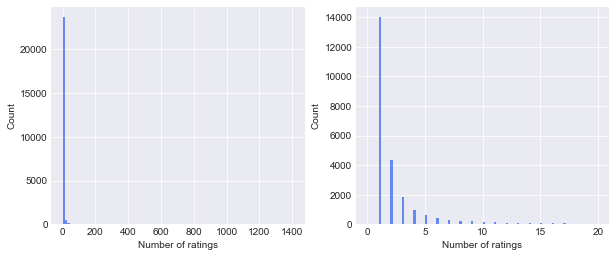

In [19]:
nummax = userrating['num of ratings'].max()
nummin = userrating['num of ratings'].min()
print('The maximum number of ratings from one user is: ' + str(nummax))
print('The minimum number of ratings from one user is: ' + str(nummin))
# Visualize users and their ratings
# Plot the count of number of ratings from all users
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
ax1.set_xlabel('Number of ratings')
ax1.set_ylabel('Count')
hist1 = ax1.hist(x = userrating['num of ratings'], bins =100)
ax2.set_xlabel('Number of ratings')
ax2.set_ylabel('Count')
hist2 = ax2.hist(x = userrating['num of ratings'], bins =100, range=(0,20))

#### Q4: Distribution of mean user ratings
Most of the ratings fall between 6 to 9. Still there are peaks at ratings = integer because there are many users who only give one rating. 

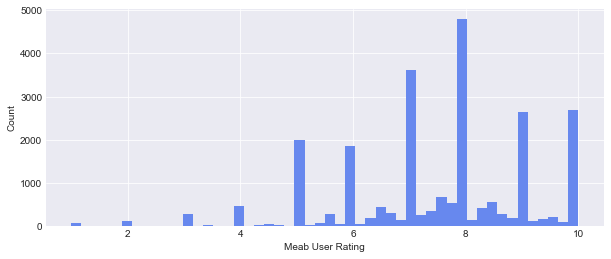

In [20]:
# Visualize the count of ratings from all users.
# It makes sence that there are several peaks which is probably from the many users 
# that only give one rating. 
plt.figure(figsize=(10,4))
plt.xlabel('Meab User Rating')
plt.ylabel('Count')
userrating['rating'].hist(bins=50)

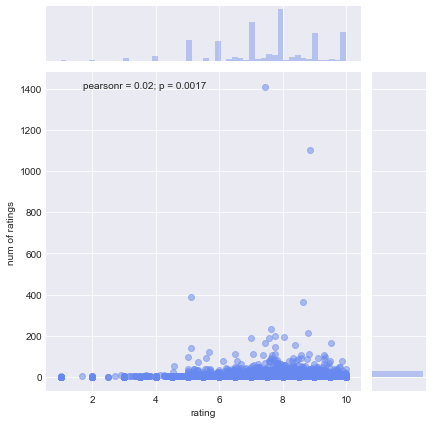

In [21]:
sns.jointplot(x='rating',y='num of ratings',data=userrating,alpha=0.5)

#### Filter out the users with less than 4 rating

People have different tendencies to rate books. Some already give 10 to a mediocre book, while others do not give 10 unless it is the perfect book for them. Such tendencies can be seen in the figure below. On the right side there is a bump from users with a mean rating of 10, indicating that they really liked all books (or they only rated books they really like…). We can also see that there are nearly no notoriuous downvoters rating all books with a 1. Such tendencies are going to be important for collaborative filtering later, and are typically dealt with by subtracting the user’s mean rating from their ratings.

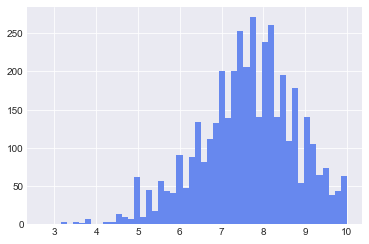

In [22]:
userrating[userrating['num of ratings']>3]['rating'].hist(bins=50)

In [23]:
# Drop rating column
userrating.drop('rating', axis =1, inplace=True)

### Section II:
### Prepare the data for the recommender system

In this section. We further process the data in the following two steps:

1. Filter out the users with less than 4 ratings in df dataframe
2. Map the user id to [0, num_users) and book id to [0, num_books). So that the user id and book is can be directly used as indexes of Rating matrix. Where the rows represent different user and the columns represent different books. 

In [24]:
# From the histograms, we can see that more than 35,000 users in 
# total 68092 users only gives one rating 
userrating['user_id']=userrating.index
df = df.merge(userrating, on = 'user_id')
df.head()

,book_id,implicit,rating,user_id,num of ratings
0,076790382X,NaN,7,274005,8
1,0061319694,NaN,5,274005,8
2,0140446028,NaN,10,274005,8
3,0684853787,NaN,7,274005,8
4,0140441719,NaN,3,274005,8


In [25]:
# We removed users who rated fewer than 4 books
df = df[df['num of ratings']>3]
df.head()

,book_id,implicit,rating,user_id,num of ratings
0,076790382X,NaN,7,274005,8
1,0061319694,NaN,5,274005,8
2,0140446028,NaN,10,274005,8
3,0684853787,NaN,7,274005,8
4,0140441719,NaN,3,274005,8


Print the number of books and number of users after filtering

In [26]:
# Get Number of Users and Number of Books in Filtered Data
n_users = df.user_id.nunique()
n_books = df.book_id.nunique()

print('Num. of Users: ' + str(n_users))
print('Num of Books: ' + str(n_books))

Num. of Users: 4135
Num of Books: 31168


##### Sparsity of rating  matrix

The matrix has sparsity > 99%, so very sparse with most entries 0. We need be careful with this when we later do collaboritive filtering. 

In [27]:
# Calculate the sparsity for ratings of books dataset
sparsity = round(1.0-len(df)/float(n_users*n_books), 5)
print('The sparsity level of BooksRecomender Dataset is ' + str(sparsity*100) + '%')

The sparsity level of BooksRecomender Dataset is 99.96199999999999%


Map user id from 1 to n_users and map book_id from 1 to n_books

In [28]:
# Map user_id from 1 to n_users
user_index = pd.DataFrame(df['user_id'].unique(), columns=['user_id'])
user_index.sort_values(by='user_id', axis=0, inplace= True)
user_index.reset_index(drop=True, inplace=True)
user_index['user_index']=user_index.index

# Map book_id from 1 to n_books
book_index = pd.DataFrame(df['book_id'].unique(), columns=['book_id'])
book_index.sort_values(by='book_id', axis=0, inplace= True)
book_index.reset_index(drop=True, inplace=True)
book_index['book_index']=book_index.index

Merge the user_id and book_id columns to df dataframe

In [29]:
df = df.merge(user_index, on ='user_id')
df = df.merge(book_index, on = 'book_id')

Print out the first 5 rows of df dataframe

In [30]:
df.head()

,book_id,implicit,rating,user_id,num of ratings,user_index,book_index
0,076790382X,NaN,7,274005,8,4061,21633
1,076790382X,NaN,5,89602,64,1320,21633
2,076790382X,NaN,7,171445,12,2551,21633
3,076790382X,NaN,4,8066,16,106,21633
4,0061319694,NaN,5,274005,8,4061,1466


##### Q5: What is the top 10 rated books with more than 50 reviews?

Here we only show books with more than 50 views because a book is not necessarily good with a 10 rating if only 1 userrated it. 

It is very interesting that 5 of the top 10 books come from Harry Potter Series. So we may have the trend that if a user likes a series book, he/she may other likes other book in the same series.

In [31]:
# Get the top 10 rated books with more than 50 reviews
ratings['book_id'] = ratings.index
book_ratings = ratings.merge(Books, on='book_id').set_index('title')
book_ratings[book_ratings['num of ratings']>20].sort_values('rating', ascending=False).head(10)

,rating,num of ratings,book_id,author,publisher,year
title,,,,,,
The Poisonwood Bible,9.380952,21,0060175400,Barbara Kingsolver,HarperCollins,1999
Harry Potter and the Prisoner of Azkaban (Book 3),9.214286,28,0439136369,J. K. Rowling,Scholastic,2001
Harry Potter and the Chamber of Secrets (Book 2),9.153846,26,0439064864,J. K. Rowling,Scholastic,1999
Harry Potter and the Goblet of Fire (Book 4),9.148148,27,0439139597,J. K. Rowling,Scholastic,2000
To Kill a Mockingbird,9.111111,36,0446310786,Harper Lee,Little Brown &amp; Company,1988
Seabiscuit: An American Legend,9.074074,27,0449005615,LAURA HILLENBRAND,Ballantine Books,2002
"The Fellowship of the Ring (The Lord of the Rings, Part 1)",9.000000,27,0345339703,J.R.R. TOLKIEN,Del Rey,1986
The Hobbit : The Enchanting Prelude to The Lord of the Rings,9.000000,38,0345339681,J.R.R. TOLKIEN,Del Rey,1986
Harry Potter and the Chamber of Secrets (Book 2),8.976744,43,0439064872,J. K. Rowling,Scholastic,2000


##### Q6: What are the most popular books?

We showed top 10 books that received most ratings. 

In [32]:
# Get the top 10 popular books
book_ratings.sort_values('num of ratings', ascending=False).head(10)

,rating,num of ratings,book_id,author,publisher,year
title,,,,,,
The Lovely Bones: A Novel,8.303226,155,0316666343,Alice Sebold,"Little, Brown",2002
Wild Animus,4.382114,123,0971880107,Rich Shapero,Too Far,2004
The Da Vinci Code,8.470588,85,0385504209,Dan Brown,Doubleday,2003
A Painted House,7.000000,76,044023722X,John Grisham,Dell Publishing Company,2001
The Red Tent (Bestselling Backlist),8.346667,75,0312195516,Anita Diamant,Picador USA,1998
The Catcher in the Rye,7.750000,68,0316769487,J.D. Salinger,"Little, Brown",1991
Divine Secrets of the Ya-Ya Sisterhood: A Novel,7.885246,61,0060928336,Rebecca Wells,Perennial,1997
The Secret Life of Bees,8.833333,60,0142001740,Sue Monk Kidd,Penguin Books,2003
The Firm,8.344828,58,044021145X,John Grisham,Bantam Dell Publishing Group,1992


##### Q7: Is there any correlation between number of ratings and the rating of books?

Next, we can see, whether we can find any associations of features with a book’s rating. 

In [33]:
# Is there any correlation between number of ratings 
# and the rating of books
m = np.corrcoef(x=book_ratings['rating'], y=book_ratings['num of ratings'])
print('The correlation between number of ratings and average rating of books is: ' + str(m[0,1]))

The correlation between number of ratings and average rating of books is: 0.0249605504234


We found that the number of ratings of does not affect the rating of books
Hopefully other factors we don't have explicitly are affecting the ratings
i.e. the quality of the book.


#### Section Summary: 

In this section, We identified some interesting aspects of this book datasets. In summary, observed effects on book rating are rather small, suggesting that book rating is mainly driven by other aspects, hopefully including the quality of the book itself.


### Section III:
### Recommender System: Collaborative filtering

Collaboritve filtering is a standard method for product recommendations. We implemented two kinds of collorarive filtering: **Memory-based** CF and **Model-based CF**. The main idea of thse two CF are explained below.

1. **Memory-based CF:** Memory-Based CF approaches can be divided into two main sections: **user-item filtering** and **item-item filtering**. 
2. **Model-based CF:** Model-based CF is based on matrix factorization, which works better with scalability and sparsity than Memory-based CF.


##### Construct the Rating matrix 

I construct a rating matrix from the dataframe df. A sample user-book rating will look like 

<img class="aligncenter size-thumbnail img-responsive" src="http://s33.postimg.org/ay0ty90fj/BLOG_CCA_8.png" alt="blog8"/>


Then I split this matrix entries to two matrices: train data matrix and test data matrix. The training matrix contains 75% of the ratings and the testing matrix contains 25% of the ratings

In [34]:
# A model-based Collaborative Filtering system
# Train Test split
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size=0.25)

#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_books))
for line in train_data.itertuples():
    train_data_matrix[line[6], line[7]] = line[3]  
    
test_data_matrix = np.zeros((n_users, n_books))
for line in test_data.itertuples():
    test_data_matrix[line[6], line[7]] = line[3]

#### Memory-based CF:
A *user-item filtering* will take a particular user, find users that are similar to that user based on similarity of ratings, and recommend items that those similar users liked. 

In contrast, *item-item filtering* will take an item, find users who liked that item, and find other items that those users or similar users also liked. It takes items and outputs other items as recommendations. 

* *Item-Item Collaborative Filtering*: “Users who liked this item also liked …”
* *User-Item Collaborative Filtering*: “Users who are similar to you also liked …”

We can bulid similarity matrix using *cosine similarity*, where the ratings are seen as vectors in ``n``-dimensional space and the similarity is calculated based on the angle between these vectors. 
Cosine similiarity for users *a* and *m* can be calculated using the formula below, where you take dot product of  the user vector *$u_k$* and the user vector *$u_a$* and divide it by multiplication of the Euclidean lengths of the vectors.
<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?s_u^{cos}(u_k,u_a)=\frac{u_k&space;\cdot&space;u_a&space;}{&space;\left&space;\|&space;u_k&space;\right&space;\|&space;\left&space;\|&space;u_a&space;\right&space;\|&space;}&space;=\frac{\sum&space;x_{k,m}x_{a,m}}{\sqrt{\sum&space;x_{k,m}^2\sum&space;x_{a,m}^2}}"/>

To calculate similarity between items *m* and *b* you use the formula:

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?s_u^{cos}(i_m,i_b)=\frac{i_m&space;\cdot&space;i_b&space;}{&space;\left&space;\|&space;i_m&space;\right&space;\|&space;\left&space;\|&space;i_b&space;\right&space;\|&space;}&space;=\frac{\sum&space;x_{a,m}x_{a,b}}{\sqrt{\sum&space;x_{a,m}^2\sum&space;x_{a,b}^2}}
"/>

Then we make predictions based on other using ratings together with their similairity:
<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?\hat{x}_{k,m}&space;=&space;\bar{x}_{k}&space;&plus;&space;\frac{\sum\limits_{u_a}&space;sim_u(u_k,&space;u_a)&space;(x_{a,m}&space;-&space;\bar{x_{u_a}})}{\sum\limits_{u_a}|sim_u(u_k,&space;u_a)|}"/>
The idea here is that some users may tend always to give high or low ratings to all books. The relative difference in the ratings that these users give is more important than the absolute values. To give an example: suppose, user *k* gives 8 to his favourite books and 6 to all other good books. Suppose now that another user *t* rates books that he/she likes with 10, and the books he/she fell asleep over with 5. These two users could have a very similar taste but treat the rating system differently. 

When making a prediction for item-based CF we don't need to correct for users average rating since query user itself is used to do predictions.

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?\hat{x}_{k,m}&space;=&space;\frac{\sum\limits_{i_b}&space;sim_i(i_m,&space;i_b)&space;(x_{k,b})&space;}{\sum\limits_{i_b}|sim_i(i_m,&space;i_b)|}"/>

In [35]:
from scipy import spatial
from sklearn.metrics.pairwise import cosine_similarity
user_similarity = cosine_similarity(train_data_matrix)
item_similarity = cosine_similarity(train_data_matrix.T)

In [39]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [36]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        np.fill_diagonal(similarity,0)
        index = np.where(similarity.any(axis=1))
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = mean_user_rating[:,np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
        np.nan_to_num(pred,copy=False)
    elif type == 'item':
        np.fill_diagonal(similarity,0)
        index = np.where(similarity.any(axis=1))
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
        np.nan_to_num(pred, copy=False)
    return pred

In [40]:
import warnings
warnings.filterwarnings("ignore")

In [41]:
user_prediction = predict(train_data_matrix, user_similarity, type='user')
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))

User-based CF RMSE: 7.84492645405784


In [42]:
item_prediction = predict(train_data_matrix, item_similarity, type='item')
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

Item-based CF RMSE: 7.488658120701748


#### Model-based CF:

Model-based Collaborative Filtering is based on **matrix factorization (MF)** which has received greater exposure, mainly as an unsupervised learning method for latent variable decomposition and dimensionality reduction. Matrix factorization is widely used for recommender systems where it can deal better with scalability and sparsity than Memory-based CF. The goal of MF is to learn the latent preferences of users and the latent attributes of items from known ratings (learn features that describe the characteristics of ratings) to then predict the unknown ratings through the dot product of the latent features of users and items. 
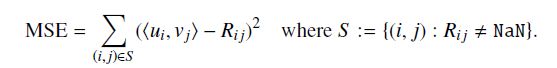
When we have a very sparse matrix, with a lot of dimensions, by doing matrix factorization I can restructure the  user-item matrix into low-rank structure, and you can represent the matrix by the multiplication of two low-rank matrices, where the rows contain the latent vector. You fit this matrix to approximate your original matrix, as closely as possible, by multiplying the low-rank matrices together, which fills in the entries missing in the original matrix.

In [252]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

#get SVD components from train matrix. Choose k.
u, s, vt = svds(train_data_matrix, k = 50)
s_diag_matrix=np.diag(s)
model_prediction = np.dot(np.dot(u, s_diag_matrix), vt)
print('Model-based CF RMSE: ' + str(rmse(model_prediction, test_data_matrix)))

Model-based CF RMSE: 7.848888519548369


#### Model-based CF with l2 regularization

To avoid overfitting, we define the loss function to be
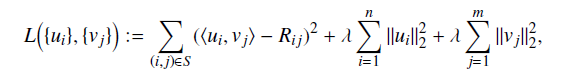

I need to minimize the RMSE together with regularization on u and v. I use the following algorithm:

1. Randomly initialize ui and vj
2. Minimize the loss function treating u and v as constant vectors
3. Iterate over 1 and 2 untill both u and v are converged. 

In [232]:
def MLF(R, d, Lambda):
    row, col= R.shape
    U =  np.random.rand(row, d)
    V = np.random.rand(d, col)        
    Rnew = R.copy()
    for i in range(300):
        current = np.dot(U, V)
        U=updateU(Rnew,V,Lambda)
        V=updateV(Rnew,U,Lambda)
    out = np.dot(U,V)
    prediction = out
    return prediction
def updateU(R,V,Lambda):
    U = np.linalg.solve(np.dot(V, V.T)+Lambda*np.eye(len(V)), np.dot(V, R.T))        
    return U.T
def updateV(R,U,Lambda):
    V = np.linalg.solve(np.dot(U.T,U)+Lambda*np.eye(len(U[0])), np.dot(U.T, R))
    return V

In [251]:
model_r_prediction = MLF(train_data_matrix, 50, 0.001)

In [253]:
print('Model-based CF with l2 regularization RMSE: ' + str(rmse(model_r_prediction, test_data_matrix)))

Model-based CF with l2 regularization RMSE: 7.84902261289416


#### An example of predictions:

For user with user_id 0, we print out the predictions of top 10 books to user 0. 

In [123]:
value, count = np.unique(test_data_matrix.nonzero()[0], return_counts=True)

In [275]:
userid = value[count==18][1]
print('Top 10 recommendations for user' + str(userid))

Top 10 recommendations for user227


In [276]:
print('Top 10 from test matrix are: \n' + str(np.argsort(test_data_matrix[userid,:])[::-1][0:10]))

Top 10 from test matrix are: 
[20109  9734  8171  5066 19129 10297 15086 10391  9037 11661]


In [277]:
print('Top 10 from user-based CF are: \n' + str(np.argsort(user_prediction[userid,:])[::-1][0:10]))

Top 10 from user-based CF are: 
[ 5206 19286 11172   116 19422  5322 19088  9305   175 11661]


In [278]:
print('Top 10 from model-based CF are: \n' + str(np.argsort(model_prediction[userid,:])[::-1][0:10]))

Top 10 from model-based CF are: 
[ 5206 19286  4809 19422  7785  9960  1478 17983  5567  9893]


In [279]:
print('Top 10 from model-based CF with regularization are: \n' + str(np.argsort(model_r_prediction[userid,:])[::-1][0:10]))

Top 10 from model-based CF with regularization are: 
[ 5206 12340 11172  4315 19286 19422 17419 13932  4786 13342]


In [280]:
print('Top 10 from item-based CF are: \n' + str(np.argsort(item_prediction[userid,:])[::-1][0:10]))

Top 10 from item-based CF are: 
[  175 17198 28926 12116 26202 25125 20167 24877 11919 25615]


In [281]:
print('Top 10 from train matrix are: \n' + str(np.argsort(train_data_matrix[userid,:])[::-1][0:10]))

Top 10 from train matrix are: 
[18457  5206 28073 24915 18300 10164  8140 18163 14434 19422]


### Conclusions:

Although the item-based CF gives relatively low RMSE, actually user-based CF and model-based CF gives similar and better predictions. Due to the nature of recommender systems, it is hard to quantify the prediction error. 

Discussion on sparsity: the rating matrix we are dealing with is very sparse, which will result in zero rows in the user-similarity and item-similarity matrces. Thus we are not able to recommend correctly books for this users, which is essentially recommending randomly. So one advantage of model based regularization is the ability to handle very sparse matrix.

#### Future Work:

One reason that these recommendations being not accurate would be the fact that more data (user-item) ratings are needed. So we should further proceed on running the same recommender system on the whole dataset on AWS. 

Also, we should combine the recommendations from different method, which may give a better recommendation (similar item as random forest).
